In [5]:
import pickle
import matplotlib as plt
import json
import tqdm
import pandas as pd
import datetime
import math

from PIL import Image

# with open('../llm_gen/qa_dict_20250314160130.pkl', 'rb') as f:
#     llm_result_dict = pickle.load(f)

In [6]:
from matplotlib.patches import Arc


def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][2]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][3] - l2xy[0][4]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = str(angle)+u"\u00b0")


def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
    angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][5] + vertices[-1][6]) / 2.0

    #print x_width, y_width

    separation_radius = max(x_width/2.0, y_width/2.0)

    return [ x_width + separation_radius, y_width + separation_radius, angle]    


# angle_plot = get_angle_plot(diagram_ax.get_lines()[0], diagram_ax.get_lines()[1], 1)
# angle_text = get_angle_text(angle_plot) 

# diagram_ax.add_patch(angle_plot) # To display the angle arc
# diagram_ax.text(*angle_text) # To display the angle value

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])


# fig, ax = plt.subplots()
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")

# # Plot two crossing lines and label each angle between them with the above
# # ``AngleAnnotation`` tool.
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")

# am1 = AngleAnnotation(center, p1[1], p2[1], ax=ax, size=75, text=r"$\alpha$")
# am2 = AngleAnnotation(center, p2[1], p1[0], ax=ax, size=35, text=r"$\beta$")
# am3 = AngleAnnotation(center, p1[0], p2[0], ax=ax, size=75, text=r"$\gamma$")
# am4 = AngleAnnotation(center, p2[0], p1[1], ax=ax, size=35, text=r"$\theta$")


# # Showcase some styling options for the angle arc, as well as the text.
# p = [(6.0, 400), (5.3, 410), (5.6, 300)]
# ax.plot(*zip(*p))
# am5 = AngleAnnotation(p[1], p[0], p[2], ax=ax, size=40, text=r"$\Phi$",
#                       linestyle="--", color="gray", textposition="outside",
#                       text_kw=dict(fontsize=16, color="gray"))

In [71]:
angles = 'ABC $2131414 \\circ \\frac{1}{2} \pi$'
angles = angles.strip().split(' ')
name = angles[0]
text = ' '.join(angles[1:])

print([name, text])

['ABC', '$2131414 \\circ \\frac{1}{2} \\pi$']


In [72]:
content = '\n\n ;; angles to annotate: ABC $13\\circ$ \n ;; angles to annotate: CDS $\\frac{1}{2} \\pi$'

In [78]:
lines = content.split('\n')
angles = []
for line in lines:
    line_split = line.split(';; angles to annotate: ')
    if len(line_split) > 1:
        angles.append(line_split[1].strip())

names = []
texts = []
for angle in angles:
    angle = angle.strip().split(' ')
    names.append(angle[0])
    texts.append(' '.join(angle[1:]))
angles = [[names[i], texts[i]] for i in range(len(names))]

angles

[['ABC', '$13\\circ$'], ['CDS', '$\\frac{1}{2} \\pi$']]

In [ ]:
['(param B point)', '(param C point)', '(define O point (midp B C))', '(param D point (on-seg B O))', '(param E point (on-seg O C))', '(define lineBD line (line B D))', '(define lineCE line (line C E))', '(define A point (inter-ll lineBD lineCE))', '(define lineOD line (line O D))', '(define lineOE line (line O E))', '(assert (= (uangle B A C) (div (mul 70 pi) 180)))', '', ';; segments to connect: BC BD CE OD OE AB AC', ';; angle to annotate: BAC $70^\\circ$']

In [ ]:
# aaa = ['(param A point)', '(param B point)', '(param C point)', '(assert (= (uangle B A C) (div (mul 90 pi) 180)))', '(assert (= (uangle A B C) (div (mul 20 pi) 180)))', '(assert (= (uangle A C B) (div (mul 70 pi) 180)))', ';; segments to connect: AB AC BC', ';; angle to annotate: BAC $\\frac{1}{2} \\pi$', ';; angle to annotate: CAB $angle 2$', ';; angle to annotate: ABC $20^\\circ$',  ';; angle to annotate: ACB $70^\\circ$', ';; segment to annotate: BC $\\frac{2}{3}cm$']
aaa = ['(param A point)', '(param B point)', '(param C point)', '(param D point (on-seg C B))'
       '(assert (= (uangle B A C) (div (mul 90 pi) 180)))', '(assert (= (uangle A B C) (div (mul 20 pi) 180)))', '(assert (= (uangle A C B) (div (mul 70 pi) 180)))',
       ';; segments to connect: AB AC BC AD',
       ';; angle to annotate: DAC $40^\\circ$',';; angle to annotate: DAB $\\frac{1}{2} \\pi$', ';; angle to annotate: ABC $20^\\circ$',  ';; angle to annotate: ACB $70^\\circ$',
       ';; segment to annotate: BC $\\frac{2}{3}cm$']

from s1_llm_generator_r1 import *
content = '\n'.join(aaa)
content = '``` \n ' + content + ' \n ```'
inputs = [content, 0, 0]
res = gmb_draw(inputs)
diagram = res[1][0]
diagram.plot(show=False, save=True, return_fig=True, fname='/mnt/afs/qinshenghao/projects/create_vision_ds/geo-model-builder/src/aaa.png')

2025-04-27 14:31:10.487890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 14:31:10.868878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745735471.009810   17416 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745735471.049786   17416 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745735471.367670   17416 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
gmb_draw(inputs)

[' (param A point)', '(param B point)', '(param C point)', '(param D point (on-seg C B))(assert (= (uangle B A C) (div (mul 90 pi) 180)))', '(assert (= (uangle D A C) (div (mul 40 pi) 180)))', '(assert (= (uangle A B C) (div (mul 20 pi) 180)))', '(assert (= (uangle A C B) (div (mul 70 pi) 180)))', ';; segments to connect: AB AC BC', ';; angle to annotate: DAC $40^\\circ$', ';; angle to annotate: CAB $\\frac{1}{2} \\pi$', ';; angle to annotate: ABC $20^\\circ$', ';; angle to annotate: ACB $70^\\circ$', ';; segment to annotate: BC $\\frac{2}{3}cm$ ', ' ']


[[' (param A point)',
  '(param B point)',
  '(param C point)',
  '(param D point (on-seg C B))(assert (= (uangle B A C) (div (mul 90 pi) 180)))',
  '(assert (= (uangle D A C) (div (mul 40 pi) 180)))',
  '(assert (= (uangle A B C) (div (mul 20 pi) 180)))',
  '(assert (= (uangle A C B) (div (mul 70 pi) 180)))',
  ';; segments to connect: AB AC BC',
  ';; angle to annotate: DAC $40^\\circ$',
  ';; angle to annotate: CAB $\\frac{1}{2} \\pi$',
  ';; angle to annotate: ABC $20^\\circ$',
  ';; angle to annotate: ACB $70^\\circ$',
  ';; segment to annotate: BC $\\frac{2}{3}cm$ ',
  ' '],
 [None],
 0]

(param B point) 
(param C point) 
(define O point (midp B C)) 
(define Gamma circle (diam B C)) 
(param D point (on-minor-arc Gamma B C)) 
(param E point (on-minor-arc Gamma C B)) 
(define A point (inter-ll (line B D) (line C E))) 
(assert (= (uangle B A C) (div (mul 7 pi) 18))) 



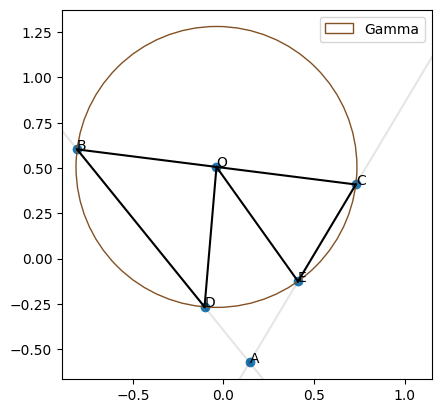

In [ ]:
ind = 1
input_caption, diagram, gmbl_code = llm_result_dict[0][2:5]
print(gmbl_code)
diagram_fig, diagram_ax= diagram.plot(show=False, save=False, return_fig=True)

In [17]:
plt.figure(diagram_fig.number)
diagram_ax = diagram_fig.gca()          # 获取当前Axes对象
plt.show(diagram_fig)              # 重新显示

<Figure size 640x480 with 0 Axes>

In [5]:
diagram_ax.get_children()

xs = [p.x for p in named_points.values()]
ys = [p.y for p in named_points.values()]
names = [n for n in named_points.keys()]

for i, n in enumerate(names):
    print(str(n), (xs[i], ys[i]))

B (np.float64(-0.8075240269017016), np.float64(0.6029463575948067))
C (np.float64(0.73019205692321), np.float64(0.4092373653147093))
O (np.float64(-0.03866598498924578), np.float64(0.506091861454758))
D (np.float64(-0.10449246093632897), np.float64(-0.2660417779499673))
E (np.float64(0.4111353723111255), np.float64(-0.12494080093819769))
A (np.float64(0.1436554036700772), np.float64(-0.5727670526645297))


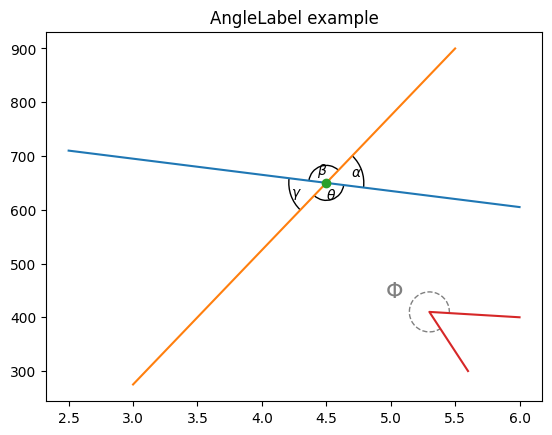

In [12]:
fig, ax = plt.subplots()
fig.canvas.draw()  # Need to draw the figure to define renderer
ax.set_title("AngleLabel example")

# Plot two crossing lines and label each angle between them with the above
# ``AngleAnnotation`` tool.
center = (4.5, 650)
p1 = [(2.5, 710), (6.0, 605)]
p2 = [(3.0, 275), (5.5, 900)]
line1, = ax.plot(*zip(*p1))
line2, = ax.plot(*zip(*p2))
point, = ax.plot(*center, marker="o")

am1 = AngleAnnotation(center, p1[1], p2[1], ax=ax, size=75, text=r"$\alpha$")
am2 = AngleAnnotation(center, p2[1], p1[0], ax=ax, size=35, text=r"$\beta$")
am3 = AngleAnnotation(center, p1[0], p2[0], ax=ax, size=75, text=r"$\gamma$")
am4 = AngleAnnotation(center, p2[0], p1[1], ax=ax, size=35, text=r"$\theta$")


# Showcase some styling options for the angle arc, as well as the text.
p = [(6.0, 400), (5.3, 410), (5.6, 300)]
ax.plot(*zip(*p))
am5 = AngleAnnotation(p[1], p[0], p[2], ax=ax, size=40, text=r"$\Phi$",
                      linestyle="--", color="gray", textposition="outside",
                      text_kw=dict(fontsize=16, color="gray"))